In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
import re
import nltk
from tensorflow.keras.layers import BatchNormalization

# Unduh stopwords untuk Bahasa Indonesia
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_indonesia = stopwords.words('indonesian')

# Fungsi preprocessing
def preprocess_text(text):
    # Menghapus karakter yang tidak relevan dan menurunkan semua huruf menjadi kecil
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    # Menghapus stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords_indonesia])
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucifrr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
# Memuat data
data = pd.read_csv('../../models/ANN/data_set.csv')

# Menggabungkan beberapa kolom menjadi satu input
data['Input_Text'] = data['Level_Emosi'] + " " + data['Tipe_Emosi'] + " " + data['Sumber_Emosi']
data['Input_Text'] = data['Input_Text'].apply(preprocess_text)

# Gabungkan kelas dengan kurang dari 2 sampel menjadi 'Lainnya'
min_samples = 2
class_counts = data['Pertanyaan_Analisis'].value_counts()
rare_classes = class_counts[class_counts < min_samples].index
data['Pertanyaan_Analisis'] = data['Pertanyaan_Analisis'].replace(rare_classes, 'Lainnya')

# Update TfidfVectorizer dan LabelEncoder
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words=stopwords_indonesia)
X = vectorizer.fit_transform(data['Input_Text']).toarray()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Pertanyaan_Analisis'])

# Periksa jumlah kelas dan total data
print(f"Jumlah total data: {len(data)}")
print(f"Jumlah kelas unik: {len(set(y))}")

# Pastikan test_size cukup untuk jumlah kelas
test_size = max(0.2, len(set(y)) / len(y))
print(f"Adjusted test size: {test_size}")

# Lakukan train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

# Periksa distribusi kelas pada train dan test set
print("Distribusi kelas pada train set:")
print(pd.Series(y_train).value_counts())

print("\nDistribusi kelas pada test set:")
print(pd.Series(y_test).value_counts())


Jumlah total data: 4640
Jumlah kelas unik: 1461
Adjusted test size: 0.3148706896551724
Distribusi kelas pada train set:
1460    197
198       4
1089      4
620       4
1071      4
       ... 
420       1
989       1
469       1
638       1
1047      1
Name: count, Length: 1461, dtype: int64

Distribusi kelas pada test set:
1460    90
815      1
1230     1
933      1
1357     1
        ..
1090     1
653      1
1135     1
627      1
303      1
Name: count, Length: 1372, dtype: int64


d:\Project\SoulBabble\Phase 2\Machine Learning\venv\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [61]:
# Membuat model ANN dengan regularisasi tambahan
def build_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(len(set(y)), activation='softmax')  # Output layer
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
    return model


In [62]:
# Callbacks untuk Early Stopping dan Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Ubah ekstensi file menjadi .keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Membuat model
model = build_model(X_train.shape[1])

# Melatih model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
198/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0025 - loss: 13.3079   
Epoch 1: val_loss improved from inf to 11.98714, saving model to best_model.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0026 - loss: 13.3029 - val_accuracy: 0.0096 - val_loss: 11.9871
Epoch 2/50
172/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0311 - loss: 11.6019 
Epoch 2: val_loss improved from 11.98714 to 11.06528, saving model to best_model.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0326 - loss: 11.5662 - val_accuracy: 0.0616 - val_loss: 11.0653
Epoch 3/50
189/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0551 - loss: 10.6525
Epoch 3: val_loss improved from 11.06528 to 10.38835, saving model to best_model.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0554 - loss: 10.6432 - val_accuracy: 0.0623 - val_loss: 10.3884
Epoch 4/50
171/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0598 - loss: 10.0251
Epoch 4: val_loss improved from 10.

In [63]:
# Evaluasi model
score = model.evaluate(X_test, y_test)
print(f"Model Accuracy: {score[1]*100:.2f}%")

# Prediksi
y_pred = model.predict(X_test).argmax(axis=1)

# Pastikan target_names sesuai dengan kelas yang ada di y_test
unique_classes = sorted(set(y_test))  # Ambil kelas unik dari y_test
target_names = label_encoder.inverse_transform(unique_classes)  # Ambil nama kelas sesuai

# Laporan klasifikasi dengan labels yang sesuai
print(classification_report(
    y_test, 
    y_pred, 
    target_names=target_names, 
    labels=unique_classes
))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5386 - loss: 2.3655
Model Accuracy: 54.83%
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                                                                                                                                                                                                                                                                                                                                                                                                                                                                              precision    recall  f1-score   support

                                                                                            Apa yang membuat kamu merasa aneh di Aktivitas Fisik? | Apa yang bisa menyebabkan perasaan aneh kamu di Aktivitas Fisik? | Bagaimana situasi di Aktivitas Fisik mempengaruhi perasaan kamu yang aneh? | Apa yang mempengaruhi perasaan aneh kamu di Aktivitas Fisik? | Apa yan

d:\Project\SoulBabble\Phase 2\Machine Learning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Project\SoulBabble\Phase 2\Machine Learning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Project\SoulBabble\Phase 2\Machine Learning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

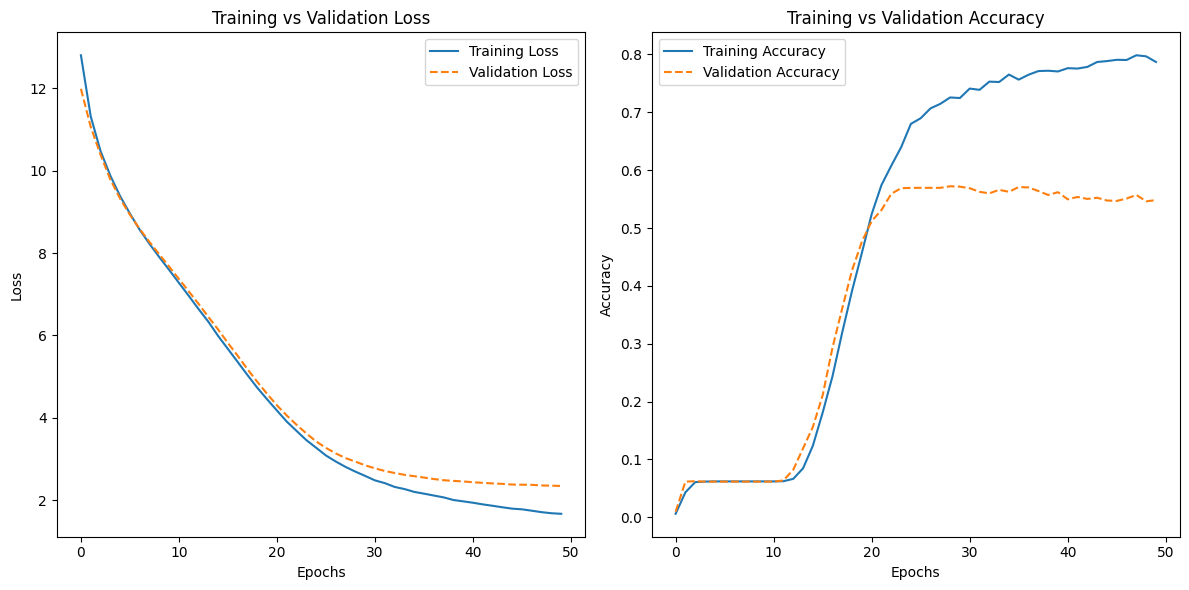

In [64]:
# Visualisasi Training dan Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [65]:
# Menyimpan model dan preprocessing tools
model.save("../../app/models/emotion_tracking_model.keras")
joblib.dump(vectorizer, '../../app/models/vectorizer.pkl')  # Menyimpan TfidfVectorizer
joblib.dump(label_encoder, '../../app/models/label_encoder.pkl')  # Menyimpan LabelEncoder

print("Model, TfidfVectorizer, dan LabelEncoder berhasil disimpan!")


Model, TfidfVectorizer, dan LabelEncoder berhasil disimpan!
